In [1]:
import nltk
from nltk.corpus import semcor
import spacy
from nltk.corpus import wordnet
import string

import polars as pl

import sys
sys.path.append('..')
from utils import utils as u

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Volpe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Volpe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
WORDNET_SUPERSENSES = [
    "act",
    "animal",
    "artifact",
    "attribute",
    "body",
    "cognition",
    "communication",
    "event",
    "feeling",
    "food",
    "group",
    "location",
    "motive",
    "object",
    "person",
    "phenomenon",
    "plant",
    "possession",
    "process",
    "quantity",
    "relation",
    "shape",
    "state",
    "substance",
    "time"
]

WORDNET_SUPERSENSES_SYNSETS = {}

for word in WORDNET_SUPERSENSES:
    WORDNET_SUPERSENSES_SYNSETS[word] = wordnet.synsets(word, 'n')


In [3]:
#scelgo il verbo 
verb = 'find'

In [4]:
# recupero da un corpus tutte le frasi che lo contengono

nlp = spacy.load("en_core_web_sm")

sentences = semcor.sents()

# Converte le liste di token in stringhe
corpus = []
for sentence in sentences:
    
    str_sent = ""
    for token in sentence:
       
        if token.startswith(tuple(string.punctuation)):
            str_sent += token
        else:
            str_sent += ' '+token
    str_sent = str_sent.replace("''", "")
    str_sent = str_sent.replace("``", "")

    doc = nlp(str_sent)
    if any(token.lemma_ == verb for token in doc):
        corpus.append(str_sent)

print(len(corpus))


720


In [5]:
semantic_roles = {}
i = 1
for sentence in corpus:
    doc = nlp(sentence)
    # Estrai ruoli sintattici e tipi semantici
    obj_synset = []
    subj_synset = []
    for token in doc:

        if token.dep_ == "nsubj":
            word = u.lemmatize_word(token.text, 'n')
            subj_synset = wordnet.synsets(word, 'n')
        if token.dep_ == "dobj":
            word = u.lemmatize_word(token.text, 'n')
            obj_synset = wordnet.synsets(word, 'n')

        if len(obj_synset) > 0 and len(subj_synset) > 0:
            # Mappatura a tipi semantici utilizzando WordNet (solo come esempio)
            semantic_roles[i] = {}
            semantic_roles[i]['nsubj'] = subj_synset
            semantic_roles[i]['dobj'] = obj_synset
    i += 1


In [6]:
def get_supersenses(sense):
    senses = [sense]

    while senses:
        current_synset = senses.pop(0)

        for word in WORDNET_SUPERSENSES_SYNSETS:

            if current_synset in WORDNET_SUPERSENSES_SYNSETS[word]:
                return word

        hypernyms = current_synset.hypernyms()
        senses.extend(hypernyms)
    return None


In [7]:
def get_best_supersenses(sense):
    senses = [sense]
    supersenses_list = {}

    while senses:
        #print(senses)
        current_synset = senses.pop(0)

        for word in WORDNET_SUPERSENSES_SYNSETS:

            if current_synset in WORDNET_SUPERSENSES_SYNSETS[word]:
                if word not in supersenses_list:
                    supersenses_list[word] = 1
                else:
                    supersenses_list[word] += 1

        hypernyms = current_synset.hypernyms()
    
        senses.extend(hypernyms)
    if len(supersenses_list) > 0:
        return next(iter(supersenses_list))
    else:
        return None




In [8]:
#per ogni coppia sogetto, oggetto vado a prendere i supersense

supersenses_subj_obj = {}
for index in semantic_roles:
    supersenses_subj_obj[index] = []
    if 'nsubj' in semantic_roles[index].keys() and 'dobj' in semantic_roles[index].keys():
        for synset_subj in semantic_roles[index]['nsubj']:
            supersenses_subj = get_best_supersenses(synset_subj)
            for synset_obj in semantic_roles[index]['dobj']: 
                supersenses_obj = get_best_supersenses(synset_obj)
                if supersenses_subj is not None and supersenses_obj is not None:
                    supersenses_subj_obj[index].append((supersenses_subj, supersenses_obj))
    supersenses_subj_obj[index] = list(set(supersenses_subj_obj[index]))



In [9]:
semantic_patterns = {}
for index in supersenses_subj_obj:
    for couple in supersenses_subj_obj[index]:
            if couple not in semantic_patterns:
                semantic_patterns[couple] = [index]
            else:
                semantic_patterns[couple] += [index]


In [10]:
len(supersenses_subj_obj)

352

In [11]:
semantic_patterns = dict(
    sorted(semantic_patterns.items(), key=lambda item: len(item[1]), reverse=True))

for key in semantic_patterns:
    print(key, semantic_patterns[key])

tab = pl.DataFrame()



('substance', 'artifact') [87, 149, 157, 170, 172, 175, 179, 183, 200, 257, 276, 286, 301, 321, 406, 408, 414, 430, 432, 434, 455, 478, 518, 536, 570, 579, 580, 581, 582, 584, 590, 626, 635, 648, 651, 652, 653, 654, 657, 681, 684, 693, 695, 708, 709, 711]
('substance', 'cognition') [18, 33, 87, 151, 156, 163, 174, 177, 192, 195, 199, 219, 271, 276, 285, 299, 304, 320, 321, 351, 369, 385, 388, 406, 410, 424, 430, 431, 440, 455, 484, 501, 536, 539, 579, 584, 590, 608, 626, 634, 635, 659, 660, 710]
('communication', 'act') [33, 41, 87, 100, 149, 153, 172, 174, 225, 240, 241, 276, 285, 286, 300, 301, 311, 322, 349, 351, 406, 410, 414, 430, 436, 459, 540, 543, 562, 576, 582, 611, 634, 635, 648, 654, 657, 681, 690, 693, 701, 710, 717, 720]
('communication', 'cognition') [33, 41, 87, 151, 156, 163, 174, 177, 182, 191, 192, 195, 199, 219, 276, 285, 299, 304, 311, 320, 351, 369, 374, 385, 388, 406, 410, 424, 430, 431, 440, 484, 501, 539, 547, 584, 608, 626, 634, 635, 659, 660, 701, 710]
('subst

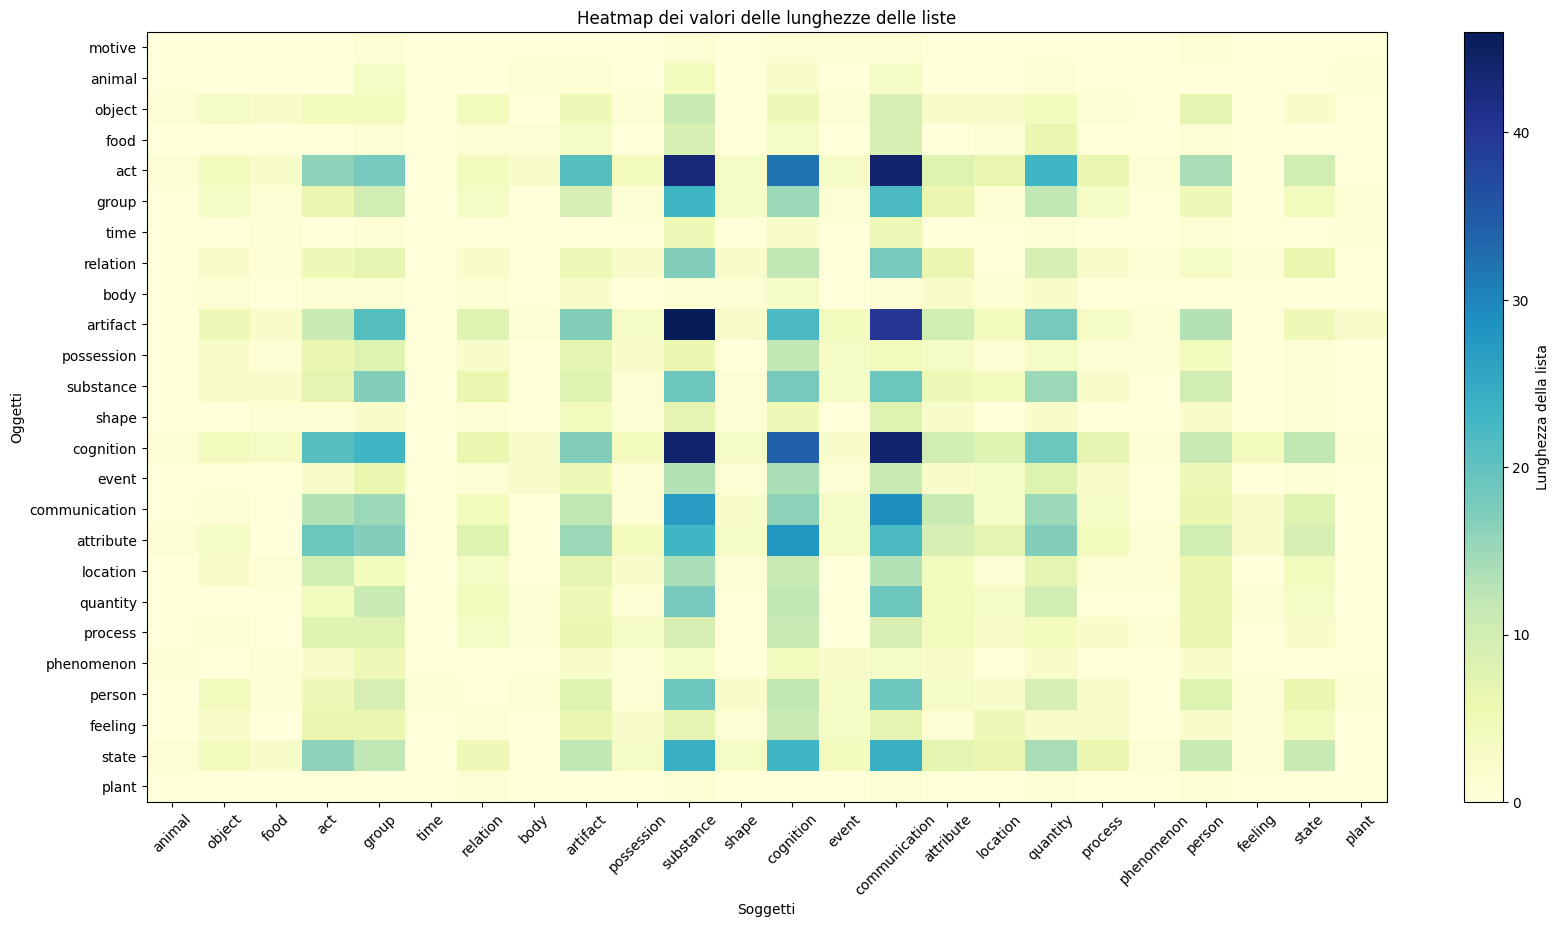

In [12]:
import pandas as pd

# I tuoi dati
dati = []

for key in semantic_patterns:
    dati.append(((key[0], key[1]), semantic_patterns[key]))

# Estrai l'elenco completo di primi e secondi elementi
primi_elementi = list(set([coppia[0] for coppia, _ in dati]))
secondi_elementi = list(set([coppia[1] for coppia, _ in dati]))

# Creazione del DataFrame
df = pd.DataFrame(columns=primi_elementi, index=secondi_elementi)

# Riempi il DataFrame con i valori delle lunghezze delle liste
for coppia, lista in dati:
    primi_elem = coppia[0]
    secondo_elem = coppia[1]
    valore = len(lista)
    df.loc[secondo_elem, primi_elem] = valore

# Visualizzazione del DataFrame
import matplotlib.pyplot as plt

# ... (Codice per creare il DataFrame)


df = df.fillna(0)
# Esempio 1: Heatmap
plt.figure(figsize=(20, 10))
plt.title('Heatmap dei valori delle lunghezze delle liste')
plt.xlabel('Soggetti')
plt.ylabel('Oggetti')
plt.imshow(df, cmap='YlGnBu', aspect='auto')
plt.colorbar(label='Lunghezza della lista')
plt.xticks(ticks=range(len(primi_elementi)), labels=primi_elementi, rotation=45)
plt.yticks(ticks=range(len(secondi_elementi)), labels=secondi_elementi)
plt.show()
